##### Observations of Snow from space - snow phenology

##### What does this notebook do?
This notebook describes

In [1]:
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff
import os

sys.path.append('../10_Scripts')
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting

In [2]:
# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')


output='results/tas/notebook/'

In [3]:
# lat, lon, buffer_m, buffer_n = -36.86895, 147.276, 30000, 30000 #vic
lat, lon, buffer_m, buffer_n = -41.56728, 147.67106, 10000, 10000 #tas ben lomond
#lat, lon, buffer_m, buffer_n = -36.46, 148.26, 5000, 5000 #nsw
# time_range = ('2010-01-01', '2018-12-31')
# time_range1 = ('2005-01-01', '2005-12-31')
time_range = ('2017-01-01', '2017-12-31')
time_range10s = ('2010-01-01', '2014-12-31')
time_range10s1 = ('2015-01-01', '2018-12-31')
time_range00s = ('2000-01-01', '2004-12-31')
time_range00s1 = ('2005-01-01', '2009-12-31')
time_range90s = ('1990-01-01', '1994-12-31')
time_range90s1 = ('1995-01-01', '1999-12-31')
time_range80s = ('1987-01-01', '1989-12-31')


resolution = (-25, 25)

# why 0.3
landsat_goodquality_prop = 0.1

# working out thresholds - geotiff for a number of different ones (methods for verification etc)
# fine tuned for different elevations.. 
#- trees change at different altidudes etc.. (depeding on region accurate thesholds can vary usually btwn 0.0-0.5)
ndsi_threshold = 0.2
ndvi_threshold = 0.3
ndwi_threshold = 0.15
red_threshold = 1000

In [4]:
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}
query10s = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range10s,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}
query10s1 = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range10s1,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

query00s = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range00s,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}
query00s1 = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range00s1,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

query90s = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range90s,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}
query90s1 = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range90s1,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

query80s = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range80s,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

In [82]:
DEAPlotting.display_map(y=query['y'], x=query['x'])

In [97]:
# Preview area that data will be loaded for:
# DEAPlotting.display_map(y=query['y'], x=query['x'])

In [5]:
# creating a snow mask
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query,
                                               #mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=False)



Loading ls8
    Loading 20 filtered ls8 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls5
    Skipping ls5; no valid data for query
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [6]:
snow_mask = dict(    #cloud_acca='no_cloud',
                     cloud_fmask='no_cloud',
                     #cloud_shadow_acca='no_cloud_shadow',
                     cloud_shadow_fmask='no_cloud_shadow',
                     blue_saturated=False,
                     green_saturated=False,
                     red_saturated=False,
                     nir_saturated=False,
                     swir1_saturated=False,
                     swir2_saturated=False,
                     contiguous=True)

landsat_ds10s = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query10s,
                                               mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=False)

Loading ls8
    Loading 25 filtered ls8 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls5
    Loading 9 filtered ls5 timesteps
Combining and sorting ls8, ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [7]:
landsat_ds10s1 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query10s1,
                                               mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=False)

Loading ls8
    Loading 64 filtered ls8 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls5
    Skipping ls5; no valid data for query
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [8]:
landsat_ds00s = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query00s,
                                               mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=False)

Loading ls8
    Skipping ls8; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 47 filtered ls7 timesteps
Loading ls5
    Loading 25 filtered ls5 timesteps
Combining and sorting ls7, ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [9]:
landsat_ds00s1 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query00s1,
                                               mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=False)

Loading ls8
    Skipping ls8; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls5
    Loading 55 filtered ls5 timesteps
Returning ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [10]:
landsat_ds90s = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query90s,
                                               mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=False)

Loading ls8
    Skipping ls8; no valid data for query
Loading ls7
    Skipping ls7; no valid data for query
Loading ls5
    Loading 67 filtered ls5 timesteps
Returning ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [11]:
landsat_ds90s1 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query90s1,
                                               mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=False)

Loading ls8
    Skipping ls8; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 4 filtered ls7 timesteps
Loading ls5
    Loading 71 filtered ls5 timesteps
Combining and sorting ls7, ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [12]:
landsat_ds80s = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query80s,
                                               mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=False)

Loading ls8
    Skipping ls8; no valid data for query
Loading ls7
    Skipping ls7; no valid data for query
Loading ls5
    Loading 31 filtered ls5 timesteps
Returning ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [14]:
# a = xr.merge([landsat_ds10s, landsat_ds10s1])

In [19]:
landsat_ds10s

<xarray.Dataset>
Dimensions:    (time: 34, x: 801, y: 801)
Coordinates:
  * y          (y) float64 -4.617e+06 -4.617e+06 ... -4.637e+06 -4.637e+06
  * x          (x) float64 1.325e+06 1.325e+06 1.325e+06 ... 1.345e+06 1.345e+06
  * time       (time) datetime64[ns] 2010-01-20T23:43:06 ... 2014-12-01T23:52:28.500000
Data variables:
    red        (time, y, x) float64 629.0 629.0 629.0 ... 317.0 319.0 303.0
    green      (time, y, x) float64 548.0 619.0 619.0 ... 352.0 341.0 315.0
    blue       (time, y, x) float64 442.0 442.0 442.0 ... 204.0 196.0 194.0
    nir        (time, y, x) float64 2.514e+03 2.442e+03 ... 2.18e+03 2.138e+03
    swir1      (time, y, x) float64 1.675e+03 1.477e+03 ... 1.116e+03 1.091e+03
    data_perc  (time, y, x) float64 0.2714 0.2714 0.2714 ... 0.9905 0.9905
Attributes:
    crs:      EPSG:3577

In [28]:
# landsat_ds10 = DEADataHandling.load_clearlandsat(dc=dc, 
#                                                product = 'nbar',
#                                                query=query1,
#                                                mask_dict=snow_mask1,
#                                                sensors=['ls8'],
#                                                bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
#                                                masked_prop=landsat_goodquality_prop,
#                                                mask_pixel_quality=False,
#                                                ls7_slc_off=True)

In [ ]:
# comparison of acca v fmask (example time, and produce the freq plot with each...)
# nbar v nbart?

In [13]:
valid_ds10s = np.isfinite(landsat_ds10s.swir1)
valid_ds10s1 = np.isfinite(landsat_ds10s1.swir1)
valid_ds00s = np.isfinite(landsat_ds00s.swir1)
valid_ds00s1 = np.isfinite(landsat_ds00s1.swir1)
valid_ds90s = np.isfinite(landsat_ds90s.swir1)
valid_ds90s1 = np.isfinite(landsat_ds90s1.swir1)
valid_ds80s = np.isfinite(landsat_ds80s.swir1)



In [31]:
# valid_ds10 = np.isfinite(landsat_ds10.swir1)

In [15]:
# see  snow from space notebook
# calculating ndsi (and ndvi/ndwi)
ndsi_ds10s = (landsat_ds10s.green - landsat_ds10s.swir1) / (landsat_ds10s.green + landsat_ds10s.swir1)
ndvi_ds10s = (landsat_ds10s.nir - landsat_ds10s.red) / (landsat_ds10s.nir + landsat_ds10s.red)
ndsi_ds10s1 = (landsat_ds10s1.green - landsat_ds10s1.swir1) / (landsat_ds10s1.green + landsat_ds10s1.swir1)
ndvi_ds10s1 = (landsat_ds10s1.nir - landsat_ds10s1.red) / (landsat_ds10s1.nir + landsat_ds10s1.red)

ndsi_ds00s = (landsat_ds00s.green -landsat_ds00s.swir1) / (landsat_ds00s.green + landsat_ds00s.swir1)
ndvi_ds00s = (landsat_ds00s.nir - landsat_ds00s.red) / (landsat_ds00s.nir + landsat_ds00s.red)
ndsi_ds00s1 = (landsat_ds00s1.green - landsat_ds00s1.swir1) / (landsat_ds00s1.green + landsat_ds00s1.swir1)
ndvi_ds00s1 = (landsat_ds00s1.nir - landsat_ds00s1.red) / (landsat_ds00s1.nir + landsat_ds00s1.red)



# talk about testing an ndwi threshold?
# ndwi_ds = (landsat_ds1.green - landsat_ds1.nir)/(landsat_ds1.green + landsat_ds1.nir)
# too high and it removes snow - too low and pixels remain - added up over time, these form outlines of lakes


In [17]:
ndsi_ds90s = (landsat_ds90s.green - landsat_ds90s.swir1) / (landsat_ds90s.green + landsat_ds90s.swir1)
ndvi_ds90s = (landsat_ds90s.nir - landsat_ds90s.red) / (landsat_ds90s.nir + landsat_ds90s.red)
ndsi_ds90s1 = (landsat_ds90s1.green - landsat_ds90s1.swir1) / (landsat_ds90s1.green + landsat_ds90s1.swir1)
ndvi_ds90s1 = (landsat_ds90s1.nir - landsat_ds90s1.red) / (landsat_ds90s1.nir + landsat_ds90s1.red)

ndsi_ds80s = (landsat_ds80s.green - landsat_ds80s.swir1) / (landsat_ds80s.green + landsat_ds80s.swir1)
ndvi_ds80s = (landsat_ds80s.nir - landsat_ds80s.red) / (landsat_ds80s.nir + landsat_ds80s.red)

In [18]:
snow_ds1 = ndsi_ds10s > ndsi_threshold
noveg_ds10s = ndvi_ds10s < ndvi_threshold
red_ds10s = landsat_ds10s.red >1000
snow_ds10s = noveg_ds10s & snow_ds1 & red_ds10s


In [19]:
snow_ds11 = ndsi_ds10s1 > ndsi_threshold
noveg_ds10s1 = ndvi_ds10s1 < ndvi_threshold
red_ds10s1 = landsat_ds10s1.red >1000
snow_ds10s1 = noveg_ds10s1 & snow_ds11 & red_ds10s1

In [20]:
snow_ds0 = ndsi_ds00s > ndsi_threshold
noveg_ds00s = ndvi_ds00s < ndvi_threshold
red_ds00s = landsat_ds00s.red >1000
snow_ds00s = noveg_ds00s & snow_ds0 & red_ds00s


In [21]:
snow_ds01 = ndsi_ds00s1 > ndsi_threshold
noveg_ds00s1 = ndvi_ds00s1 < ndvi_threshold
red_ds00s1 = landsat_ds00s1.red >1000
snow_ds00s1 = noveg_ds00s1 & snow_ds01 & red_ds00s1

In [17]:
snow_ds9 = ndsi_ds90s > ndsi_threshold
noveg_ds90s = ndvi_ds90s < ndvi_threshold
red_ds90s = landsat_ds90s.red >1000
snow_ds90s = noveg_ds90s & snow_ds9 & red_ds90s


In [18]:
snow_ds8 = ndsi_ds80s > ndsi_threshold
noveg_ds80s = ndvi_ds80s < ndvi_threshold
red_ds80s = landsat_ds80s.red >1000
snow_ds80s = noveg_ds80s & snow_ds8 & red_ds80s


In [23]:
elev=1200

In [24]:
# Importing dem

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query1 = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),
        # 'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

# Load the DEM data
dem_ds = dc.load(product='srtm_dem1sv1_0', **query1)
dem_elev = dem_ds.dem > elev

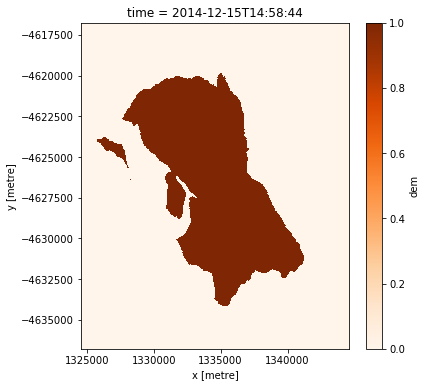

In [25]:
dem_elev.plot(cmap='Oranges', figsize=(6, 6))
## plot contour?

In [26]:
c=list(range(len(snow_ds10s.time)))
snow_prop_elev10s=[]
for i in c:
    d = valid_ds10s.isel(time=i).values * dem_elev
    f = snow_ds10s.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev10s.append(snow)

In [27]:
c=list(range(len(snow_ds10s1.time)))
snow_prop_elev10s1=[]
for i in c:
    d = valid_ds10s1.isel(time=i).values * dem_elev
    f = snow_ds10s1.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev10s1.append(snow)

In [31]:
c=list(range(len(snow_ds00s.time)))
snow_prop_elev00s=[]
for i in c:
    d = valid_ds00s.isel(time=i).values * dem_elev
    f = snow_ds00s.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev00s.append(snow)

In [33]:
c=list(range(len(snow_ds90s.time)))
snow_prop_elev90s=[]
for i in c:
    d = valid_ds90s.isel(time=i).values * dem_elev
    f = snow_ds90s.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev90s.append(snow)

In [34]:
c=list(range(len(snow_ds80s.time)))
snow_prop_elev80s=[]
for i in c:
    d = valid_ds80s.isel(time=i).values * dem_elev
    f = snow_ds80s.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev80s.append(snow)

In [30]:
snow_df10s = pd.DataFrame({'dayofyear':snow_ds10s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev10s, 'year':snow_ds10s['time.year']})
snow_df10s1 = pd.DataFrame({'dayofyear':snow_ds10s1['time.dayofyear'], 'snow_prop_elev':snow_prop_elev10s1, 'year':snow_ds10s1['time.year']})

# snow_df00s = pd.DataFrame({'dayofyear':snow_ds00s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev00s, 'year':snow_ds00s['time.year']})
# snow_df90s = pd.DataFrame({'dayofyear':snow_ds90s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev90s, 'year':snow_ds90s['time.year']})
# snow_df80s = pd.DataFrame({'dayofyear':snow_ds80s['time.dayofyear'], 'snow_prop_elev':snow_prop_elev80s, 'year':snow_ds80s['time.year']})
# df.to_csv(output+years+'phenology_freq_'+str(elev)+'.csv')

In [31]:
snow_10s = pd.concat([snow_df10s, snow_df10s1])

In [91]:
snow_df11 = pd.DataFrame({'dayofyear':snow_ds10['time.dayofyear'], 'snow_prop_elev':snow_prop_elev11, 'year':snow_ds10['time.year']})

In [34]:
elevation_2d = dem_ds.dem_h.squeeze('time')

In [35]:
contour_gdf_1200 = SpatialTools.contour_extract(z_values=1200,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_contours_1200.shp')

Operating in single array, multiple z-values mode
    Extracting contour 1200
Exporting contour shapefile to extracted_contours_1200.shp


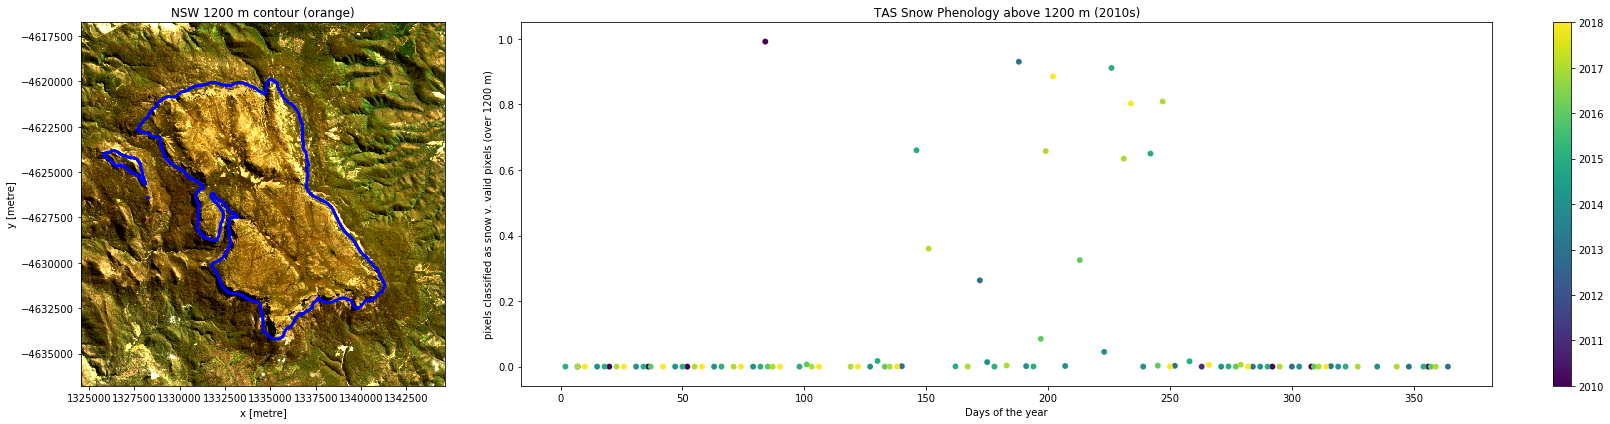

In [40]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("tas_phen_10s.pdf")

# dfs=[
#     (Snow_phen1500, 1500, 3, 0, 'orange'), 
#     (Snow_phen1200, 1200, 0, 3, 'red')
#     ]
# for i, j, k, l, m in dfs:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (25, 6),
                        gridspec_kw={'width_ratios': [2, 5]})

a=landsat_ds[['red', 'green', 'blue']].isel(time=5).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='mediumblue')
a=contour_gdf_1200.plot(ax=axes[0], linewidth=3, color='blue')
# a=contour_gdf_1200.plot(ax=axes[0], linewidth=l, color='firebrick')
a.title.set_text('NSW 1200 m contour (orange)')
plt.tight_layout()

sp = plt.scatter(snow_10s['dayofyear'], #ndsi_ds.values, 
                snow_10s['snow_prop_elev'], c=snow_10s['year'],
                cmap='viridis', marker='o', edgecolor='none',s=35)
#     plt.ylim(0,2)
plt.title('TAS Snow Phenology above 1200 m (2010s)')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1200 m)')
fig.colorbar(sp)
pdf.savefig()

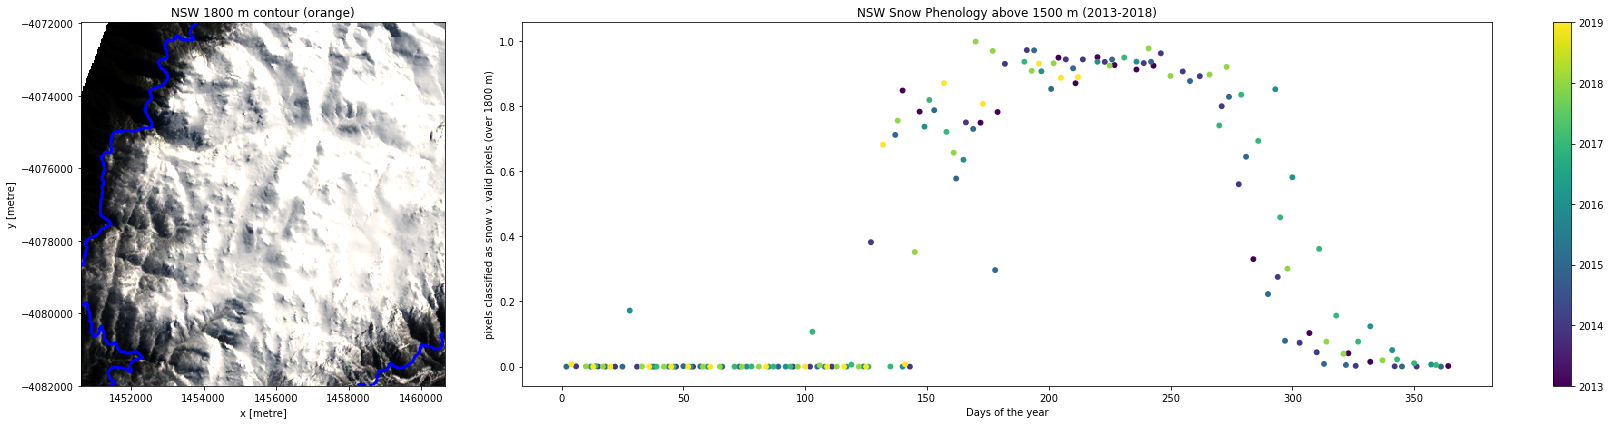

In [96]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("small_area1500_phen2013_2018.pdf")

# dfs=[
#     (Snow_phen1500, 1500, 3, 0, 'orange'), 
#     (Snow_phen1200, 1200, 0, 3, 'red')
#     ]
# for i, j, k, l, m in dfs:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (25, 6),
                        gridspec_kw={'width_ratios': [2, 5]})

a=landsat_ds2[['red', 'green', 'blue']].isel(time=20).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='mediumblue')
a=contour_gdf_1500.plot(ax=axes[0], linewidth=3, color='blue')
# a=contour_gdf_1200.plot(ax=axes[0], linewidth=l, color='firebrick')
a.title.set_text('NSW 1800 m contour (orange)')
plt.tight_layout()

sp = plt.scatter(snow_df11['dayofyear'], #ndsi_ds.values, 
                snow_df11['snow_prop_elev'], c=snow_df11['year'],
                cmap='viridis', marker='o', edgecolor='none',s=35)
#     plt.ylim(0,2)
plt.title('NSW Snow Phenology above 1500 m (2013-2018)')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1800 m)')
fig.colorbar(sp)
pdf.savefig()

In [ ]:
# comparing decades



In [220]:
# lat, lon, buffer_m, buffer_n = -36.3, 148.35, 35000, 45000
lat, lon, buffer_m, buffer_n = -36.3, 148.35, 30000, 40000
# lat1, lon1, buffer_m1, = -36.86895, 147.276, 10000, #10000 #vic

# lat1, lon1, buffer_m1 = -36.435, 148.29, 8000
# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2017-10-01', '2017-10-17')
resolution = (-25, 25)
landsat_goodquality_prop = 0.10

ndsi_threshold = 0.0
ndvi_threshold = 0.3

ndwi_threshold = 0.15

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query1 = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

In [221]:
snow_mask = dict(                cloud_acca='no_cloud',
                                 #cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 #cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)

landsat_ds5 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query1,
                                               mask_dict=snow_mask,
                                               sensors=['ls5','ls7','ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=True)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 2 filtered ls7 timesteps
Loading ls8
    Loading 2 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [223]:
landsat_ds6 = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query1,
                                               #mask_dict=snow_mask,
                                               sensors=['ls8', 'ls7', 'ls5'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=True)

Loading ls8
    Loading 2 filtered ls8 timesteps
Loading ls7
    Loading 2 filtered ls7 timesteps
Loading ls5
    Skipping ls5; no valid data for query
Combining and sorting ls8, ls7 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [222]:
ndsi_ds = (landsat_ds5.green - landsat_ds5.swir1) / (landsat_ds5.green + landsat_ds5.swir1)
ndvi_ds = (landsat_ds5.nir - landsat_ds5.red) / (landsat_ds5.nir + landsat_ds5.red)
ndwi_ds = (landsat_ds5.green - landsat_ds5.nir)/(landsat_ds5.green + landsat_ds5.nir)

In [197]:
# ndwi_ds.isel(time=2).plot(cmap='Blues', figsize=(8,8))

In [209]:
snow_ds1 = ndsi_ds > ndsi_threshold
noveg_ds = ndvi_ds < ndvi_threshold
# nowater_ds = ndwi_ds < ndwi_threshold
# snow_ds2 = noveg_ds & snow_ds & red #&nowater_ds
snow_ds = noveg_ds & snow_ds1# &nowater_ds

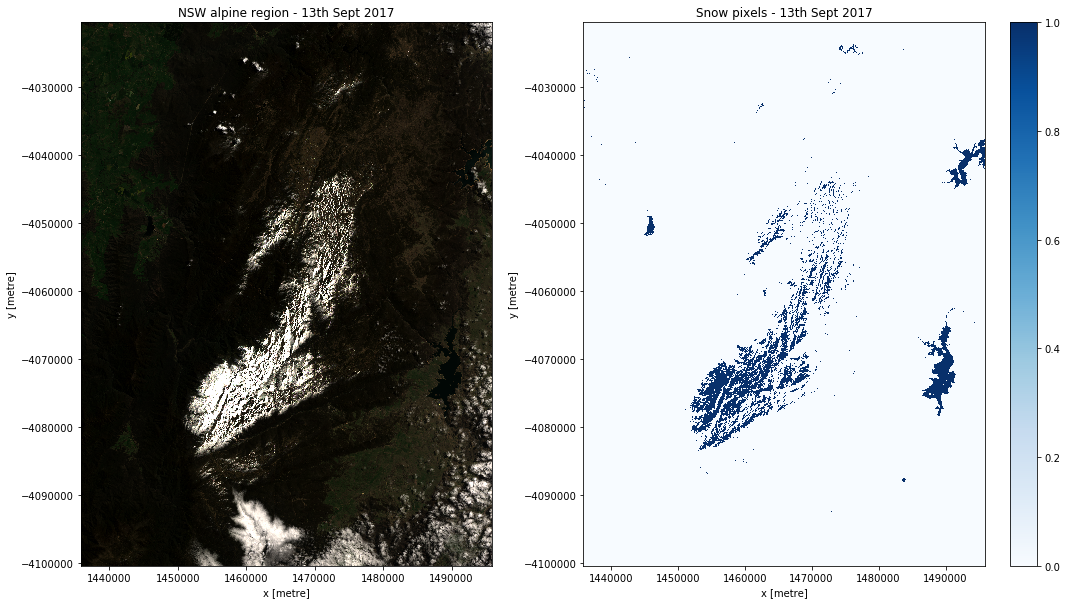

In [226]:
fig, axes = plt.subplots(ncols=2, 
                         figsize = (18, 10),
                        gridspec_kw={'width_ratios': [9,11]}
                        )
i=2

a=landsat_ds6[['red', 'green', 'blue']].isel(time=i).to_array().plot.imshow(robust=True, ax=axes[0])
b=snow_ds.isel(time=i).plot(ax=axes[1], cmap='Blues')
axes[0].set_title('NSW alpine region - 13th Sept 2017')
axes[1].set_title('Snow pixels - 13th Sept 2017')
# axes[2].set_title('NDVI - 31th May 2017')
# a.set_clim(-1,1)
b.set_clim(0, 1)
plt.savefig('nsw_snow_pixels.png')

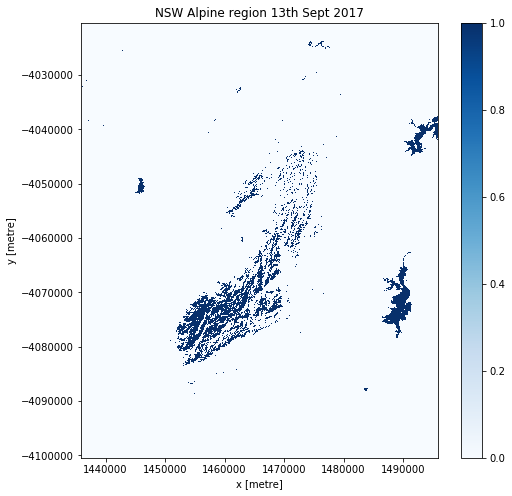

In [227]:
snow_ds.isel(time=2).plot(cmap='Blues', figsize=(8,8))
# plt.title
plt.title('NSW Alpine region 13th Sept 2017')
plt.savefig('nsw_snow_pixels1.png')

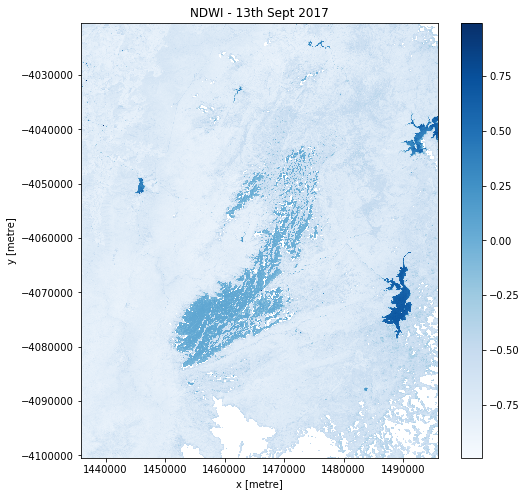

In [228]:
ndwi_ds.isel(time=2).plot(cmap='Blues', figsize=(8,8))
plt.title('NDWI - 13th Sept 2017')
plt.savefig('nsw_ndwi.png')

Text(0.5, 1.0, 'Red band - 13th Sept 2017')

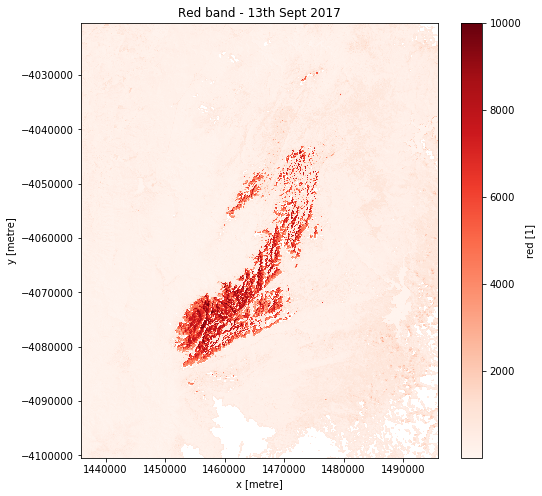

In [243]:
landsat_ds5.red.isel(time=i).plot(cmap='Reds', figsize=(8,8))
plt.title('Red band - 13th Sept 2017')
# plt.savefig('nsw_red.png')

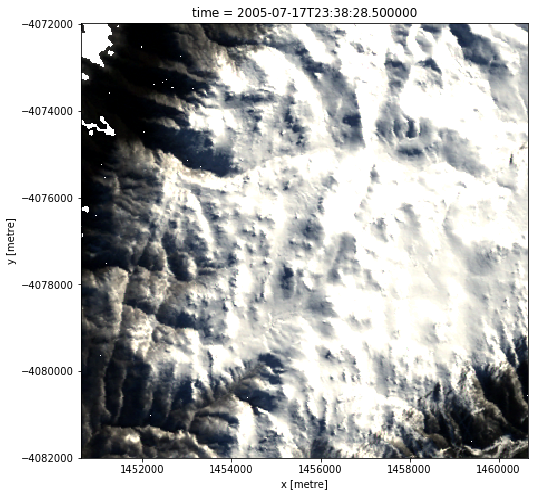

In [89]:
landsat_ds1[['red', 'green', 'blue']].isel(time=165).to_array().plot.imshow(robust=True, figsize=(8, 8))

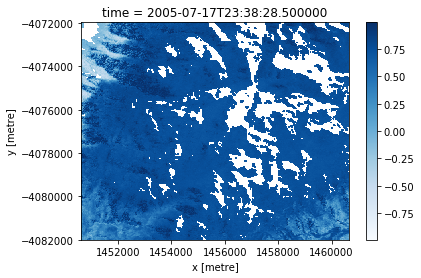

In [88]:
ndsi_ds1.isel(time=165).plot(cmap='Blues')

In [67]:
# define snow/no-snow

snow_ds1 = ndsi_ds > ndsi_threshold
noveg_ds = ndvi_ds < ndvi_threshold
nowater_ds = ndwi_ds < ndwi_threshold
snow_ds = noveg_ds & snow_ds1 & nowater_ds

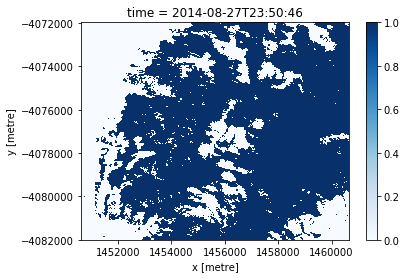

In [69]:
snow_ds.isel(time=135).plot(cmap='Blues')

In [70]:
# decadal plots, normalised sum of all images
red_threshold = 1000
red_ds = landsat_ds.red > red_threshold
snow_ds = noveg_ds & snow_ds1 & nowater_ds & red_ds

In [71]:
# different decades in a loop?

snow_sum = snow_ds.sum(dim='time')
valid_sum = valid_ds.sum(dim='time')
snow_prop = (snow_sum / valid_sum)

# # snow_prop.plot()
# # plt.savefig('decade_example.png')


# snow_sum1=snow_sum.squeeze()

# transform, projection = SpatialTools.geotransform(snow_sum1, (snow_sum1.x, snow_sum1.y), epsg=3577)
# SpatialTools.array_to_geotiff(output+year+'snow.tif',
#               snow_sum1.values, geo_transform = transform, 
#               projection = projection, 
#               nodata_val=np.nan)

# valid_sum1=valid_sum.squeeze()

# transform, projection = SpatialTools.geotransform(valid_sum1, (valid_sum1.x, valid_sum1.y), epsg=3577)
# SpatialTools.array_to_geotiff(output+year+'valid.tif',
#               valid_sum1.values, geo_transform = transform, 
#               projection = projection, 
#               nodata_val=np.nan)

Text(0.5, 1.0, 'NSW alpine region 10s')

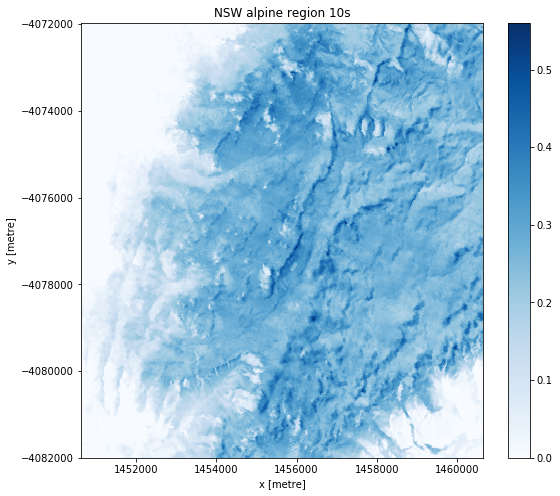

In [72]:
snow_prop.plot(figsize=(9, 8), cmap='Blues')
plt.title('NSW alpine region 10s')

In [ ]:

# snow phenology above a specific elevation
# includes creating contours



# importing a dem for the region

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query1 = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         #'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

# Load the DEM data
dem_ds = dc.load(product='srtm_dem1sv1_0', **query1)
dem_elev = dem_ds.dem > elev

# snow_elev = snow_ds.where(dem_elev.squeeze(dim='time'))
# valid_elev = valid_ds.where(dem_elev.squeeze(dim='time'))
# snow_prop = snow_elev/valid_elev

c=list(range(len(snow_ds.time)))
snow_prop_elev=[]
for i in c:
    d = valid_ds.isel(time=i).values * dem_elev
    f = snow_ds.isel(time=i).values * dem_elev
    n = np.count_nonzero(d.values)
    if n == 0:
        n = n+1
    snow =  np.count_nonzero(f.values) / n
    snow_prop_elev.append(snow)
    
    

# mask ndsi dataset with dem_1800, leaving values over 1800 m
# ndsi_elev = ndsi_ds.where(dem_elev.squeeze(dim='time'))
# calculate ndsi mean of valid pixels over 1800 m 
# mean_ndsi_elev = ndsi_elev.mean(dim=('x', 'y'))


# df = pd.DataFrame({'time':snow_ds.time, 'snow_prop_1800':snow_prop_1800, 'pixel_prop':prop_, 'pixel_over_005':prop_rel})
# df.to_csv(output+years+'NEWmask_frequency_prop.csv')

# df = pd.DataFrame({'dayofyear':snow_ds['time.dayofyear'], 'proportion':snow_ds.values, 'year':ndsi_ds['time.year']})
# df.to_csv(output+years+'phenology_freq_1800.csv')

df = pd.DataFrame({'dayofyear':snow_ds['time.dayofyear'], 'snow_prop_elev':snow_prop_elev, 'year':snow_ds['time.year']})
df.to_csv(output+years+'phenology_freq_'+str(elev)+'.csv')